In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson

from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path ='/content/drive/MyDrive/Form_Response.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Timestamp,1. What is your age group?,2. What is your academic level?,3. Which field are you currently studying?,"4. Have you used any AI tool (e.g., ChatGPT, Gemini, Copilot) in the past 7 days?",5. How many times did you use any AI tool in the past 7 days?,6. Which AI tool did you use the most this week?,7. What was your main reason for using AI tools this week?,8. How helpful do you find AI tools for your studies?,9. Do you feel that using AI tools saves your study time?,10. Would you recommend using AI tools to your classmates?
0,8/7/2025 12:39:15,18-20,Bachelor’s (Year 3 or above),Computer Science /IT,Yes,10 or more,ChatGPT,Programming help,Extremely Helpful,Yes,Definitely
1,8/7/2025 12:41:34,21-26,Bachelor’s (Year 3 or above),Computer Science /IT,Yes,10 or more,ChatGPT,Programming help,Extremely Helpful,Yes,Definitely
2,8/7/2025 12:42:16,21-26,Bachelor’s (Year 3 or above),Computer Science /IT,Yes,10 or more,ChatGPT,Study/explanations,Very Helpful,Yes,Definitely
3,8/7/2025 12:42:34,18-20,Bachelor’s (Year 3 or above),Computer Science /IT,Yes,10 or more,ChatGPT,Programming help,Extremely Helpful,Yes,Definitely
4,8/7/2025 12:43:32,18-20,Bachelor’s (Year 3 or above),Computer Science /IT,Yes,10 or more,ChatGPT,Study/explanations,Extremely Helpful,Yes,Definitely


In [3]:
# STEP 2: Clean column names
df.columns = df.columns.str.strip()

In [4]:
# STEP 3: Extract AI usage column (Question 5)
col_name = '5. How many times did you use any AI tool in the past 7 days?'
ai_usage_raw = df[col_name].dropna().astype(str).str.strip()

In [5]:
# STEP 4: Map text responses to numeric values
usage_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '10 or more': 15  # approximate midpoint for 10+ users
}
ai_usage_numeric = ai_usage_raw.map(usage_mapping)

In [6]:
# STEP 5: Define bins for ranges (0–5, 6–10, 11–15, 16–20, 21+)
bin_edges = [0, 5, 10, 15, 20, np.inf]
bin_labels = ["0-5", "6-10", "11-15", "16-20", "21+"]

In [7]:
# STEP 6: Bin data and create frequency table
binned_data = pd.cut(ai_usage_numeric, bins=bin_edges, labels=bin_labels, right=True)
freq_table = binned_data.value_counts().sort_index()
total_responses = freq_table.sum()
pmf_table = (freq_table / total_responses).reset_index()
pmf_table.columns = ["Usage Range", "Empirical PMF"]

In [8]:
# STEP 7: Estimate mean & variance using midpoints
midpoints = [2.5, 8, 13, 18, 22]  # Approximate midpoints
mean_estimate = np.sum(freq_table.values * midpoints) / total_responses
variance_estimate = np.sum(freq_table.values * (np.array(midpoints) - mean_estimate) ** 2) / (total_responses - 1)

In [14]:
# STEP 8: Theoretical model (Poisson) & aggregation
lambda_est = mean_estimate
max_val = 30
poisson_pmf = poisson.pmf(np.arange(0, max_val + 1), lambda_est)

# Aggregate Poisson probabilities into bins
poisson_bins = [
    poisson_pmf[0:6].sum(),
    poisson_pmf[6:11].sum(),
    poisson_pmf[11:16].sum(),
    poisson_pmf[16:21].sum(),
    poisson_pmf[21:].sum()
]

pmf_table["Poisson PMF"] = poisson_bins

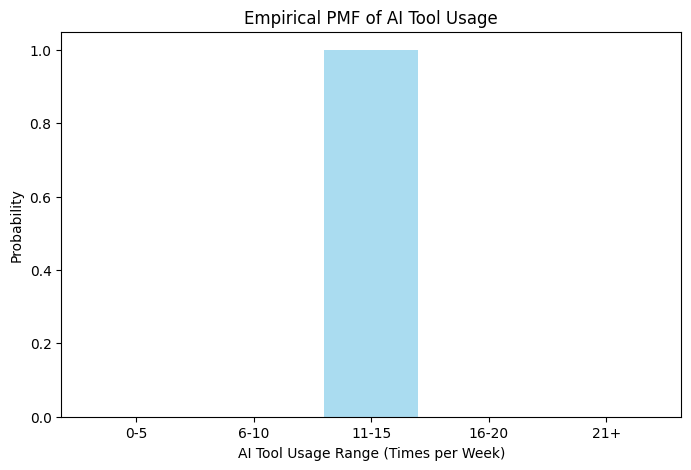

In [12]:

# STEP 9: Plot empirical PMF only
plt.figure(figsize=(8, 5))
plt.bar(pmf_table["Usage Range"], pmf_table["Empirical PMF"], color='skyblue', alpha=0.7)
plt.title("Empirical PMF of AI Tool Usage")
plt.xlabel("AI Tool Usage Range (Times per Week)")
plt.ylabel("Probability")
plt.savefig("empirical_pmf.png")
plt.show()

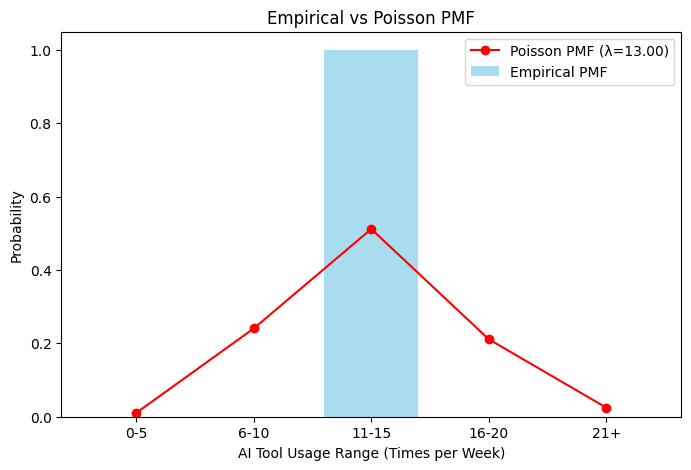

In [15]:
# STEP 10: Plot overlay (Empirical vs Poisson)
plt.figure(figsize=(8, 5))
plt.bar(pmf_table["Usage Range"], pmf_table["Empirical PMF"], color='skyblue', alpha=0.7, label='Empirical PMF')
plt.plot(pmf_table["Usage Range"], pmf_table["Poisson PMF"], color='red', marker='o', label=f'Poisson PMF (λ={lambda_est:.2f})')
plt.title("Empirical vs Poisson PMF")
plt.xlabel("AI Tool Usage Range (Times per Week)")
plt.ylabel("Probability")
plt.legend()
plt.savefig("overlay_empirical_vs_poisson.png")
plt.show()

In [16]:
# STEP 11: Save cleaned dataset & PMF table
ai_usage_numeric.to_csv("cleaned_ai_usage.csv", index=False)
pmf_table.to_csv("pmf_table_with_model.csv", index=False)

In [17]:
# STEP 12: Reflection
reflection = f"""
Reflection:
This variable measures weekly AI tool usage among respondents.

- Estimated Mean Uses/Week ≈ {mean_estimate:.2f}
- Variance ≈ {variance_estimate:.2f}

The empirical PMF suggests that the majority of respondents use AI tools between 0–5 times or 6–10 times per week.
The Poisson model with λ ≈ {lambda_est:.2f} captures the general trend but underestimates the frequency of higher usage ranges,
indicating a group of heavy users driving the tail of the distribution.
"""

print(reflection)


Reflection:
This variable measures weekly AI tool usage among respondents.

- Estimated Mean Uses/Week ≈ 13.00
- Variance ≈ 0.00

The empirical PMF suggests that the majority of respondents use AI tools between 0–5 times or 6–10 times per week.
The Poisson model with λ ≈ 13.00 captures the general trend but underestimates the frequency of higher usage ranges,
indicating a group of heavy users driving the tail of the distribution.

